# Question 3


In [91]:
# read the fits file
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.stats import binned_statistic_2d
from astropy.table import Table

# Load the data
data = Table.read('nihao_uhd_simulation_g8.26e11_xyz_positions_and_oxygen_ao.fits')
print(data.colnames)  



['x', 'y', 'z', 'A_O']


Slope: -0.0333 dex/kpc, Intercept: 9.1223, RMS: 0.0876, R²: 0.8729


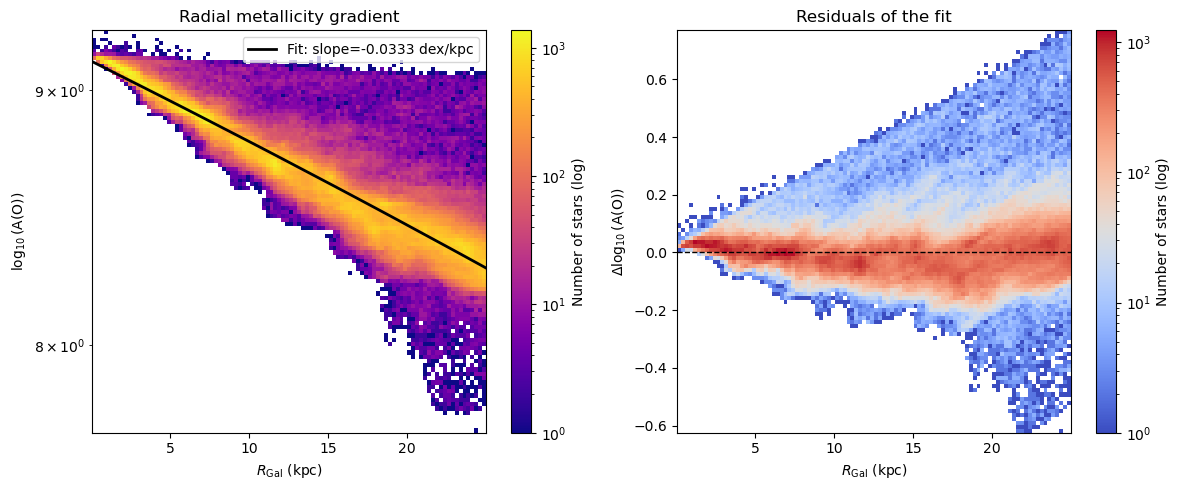

In [92]:
# Compute galactocentric radius and oxygen abundance
Rgal = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2)   # radius in kpc
A_O = data['A_O']  # oxygen abundance (log scale)

# create a linear fit
lin_fit = np.polyfit(Rgal, A_O, 1)
slope, intercept = lin_fit
rms = np.sqrt(np.mean((A_O - (slope * Rgal + intercept))**2))
r2 = 1 - (np.sum((A_O - (slope * Rgal + intercept))**2) / np.sum((A_O - np.mean(A_O))**2))
print(f"Slope: {slope:.4f} dex/kpc, Intercept: {intercept:.4f}, RMS: {rms:.4f}, R²: {r2:.4f}")

# Predicted values and residuals
A_O_fit = intercept + slope * Rgal
residuals = A_O - A_O_fit

# Create figure with 2 panels
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# (a) Logarithmic density plot: Rgal vs A(O)
h = ax[0].hist2d(
    Rgal, A_O,
    bins=100,
    cmap='plasma',
    norm=LogNorm()
)
ax[0].plot(np.sort(Rgal), intercept + slope * np.sort(Rgal),
           color='black', linewidth=2, label=f'Fit: slope={slope:.4f} dex/kpc',)
ax[0].set_xlabel(r'$R_{\mathrm{Gal}}$ (kpc)')
ax[0].set_ylabel(r'$\log_{10}(\mathrm{A(O)})$')
ax[0].set_title('Radial metallicity gradient')
ax[0].legend()
cb = fig.colorbar(h[3], ax=ax[0])
cb.set_label('Number of stars (log)')

# (b) Residuals plot: Rgal vs ΔA(O)
h2 = ax[1].hist2d(
    Rgal, residuals,
    bins=100,
    cmap='coolwarm',
    norm=LogNorm()
)
ax[1].axhline(0, color='black', linestyle='--', linewidth=1)
ax[1].set_xlabel(r'$R_{\mathrm{Gal}}$ (kpc)')
ax[0].set_yscale('log')
ax[1].set_ylabel(r'$\Delta \log_{10}(\mathrm{A(O)})$')
ax[1].set_title('Residuals of the fit')
cb2 = fig.colorbar(h2[3], ax=ax[1])
cb2.set_label('Number of stars (log)')

plt.tight_layout()
plt.savefig('figures/density_radial_gradient.png', dpi=200)
plt.show()

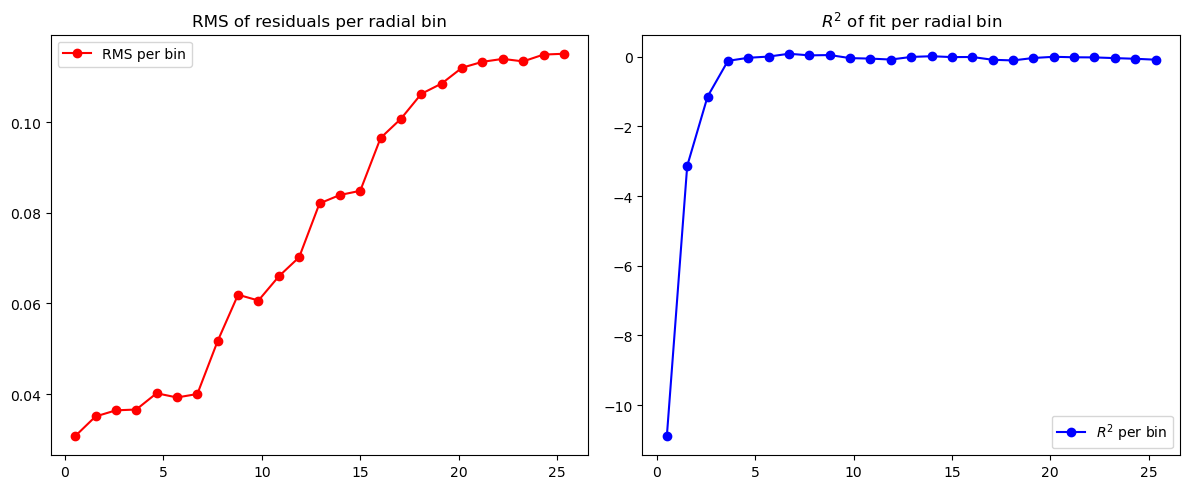

In [93]:

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# RMS per radial bin
bins = np.linspace(0, 30, 30) 
bin_centers = 0.5 * (bins[:-1] + bins[1:])
rms_per_bin = []
for i in range(len(bins) - 1):
    mask = (Rgal >= bins[i]) & (Rgal < bins[i + 1])
    if np.sum(mask) > 0:
        rms_bin = np.sqrt(np.mean(residuals[mask]**2))
        rms_per_bin.append(rms_bin)
    else:
        rms_per_bin.append(np.nan)

ax[0].plot(bin_centers, rms_per_bin, 'ro-', label='RMS per bin')
ax[0].legend()
ax[0].set_title('RMS of residuals per radial bin')

# r^2 value in radial bins
r2_per_bin = []
for i in range(len(bins) - 1):
    mask = (Rgal >= bins[i]) & (Rgal < bins[i + 1])
    if np.sum(mask) > 1:
        ss_res = np.sum(residuals[mask]**2)
        ss_tot = np.sum((A_O[mask] - np.mean(A_O[mask]))**2)
        r2_bin = 1 - (ss_res / ss_tot)
        r2_per_bin.append(r2_bin)
    else:
        r2_per_bin.append(np.nan)

ax[1].plot(bin_centers, r2_per_bin, 'bo-', label=r'$R^2$ per bin')
ax[1].legend()
ax[1].set_title(r'$R^2$ of fit per radial bin')
plt.tight_layout()
plt.show()


The linear model follows the densest region of stars as they collectively fall in A(O) with increasing radius. However, the fit does not catch the wide dispersion of stars from 5 kpc onwards. From RMS = 0.087 and R^2=0.873, we clearly are not capturing a decent portion of the data if this distribution was strictly linear. The decreasing goodness of fit is also supported by looking at how the RMS and R^2 change per radial bin.

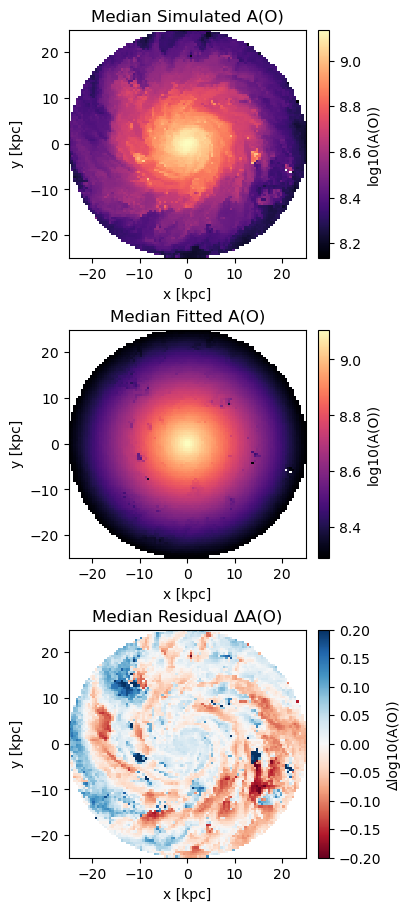

In [95]:
#--- Define spatial bins ---
nbins = 100   # choose resolution; fewer bins = smoother map
x = data['x']
y = data['y']
range_xy = [[x.min(), x.max()], [y.min(), y.max()]]

# (a) median simulated A(O)
H_sim, xedges, yedges, _ = binned_statistic_2d(
    x, y, A_O, statistic='median', bins=nbins, range=range_xy)

# (b) median fitted A(O)
H_fit, _, _, _ = binned_statistic_2d(
    x, y, A_O_fit, statistic='median', bins=[xedges, yedges])

# (c) median residuals
H_res, _, _, _ = binned_statistic_2d(
    x, y, residuals, statistic='median', bins=[xedges, yedges])

# --- Coordinates for plotting (bin centers) ---
xcenters = 0.5 * (xedges[:-1] + xedges[1:])
ycenters = 0.5 * (yedges[:-1] + yedges[1:])
Xc, Yc = np.meshgrid(xcenters, ycenters, indexing='ij')

# --- Plot ---
fig, ax = plt.subplots(3, 1, figsize=(4, 9), constrained_layout=True)

# Panel (a): Simulated A(O)
im0 = ax[0].pcolormesh(Xc, Yc, H_sim, cmap='magma', shading='auto')
ax[0].set_title('Median Simulated A(O)')
ax[0].set_xlabel('x [kpc]')
ax[0].set_ylabel('y [kpc]')
fig.colorbar(im0, ax=ax[0], label='log10(A(O))')

# Panel (b): Fitted A(O)
im1 = ax[1].pcolormesh(Xc, Yc, H_fit, cmap='magma', shading='auto')
ax[1].set_title('Median Fitted A(O)')
ax[1].set_xlabel('x [kpc]')
ax[1].set_ylabel('y [kpc]')
fig.colorbar(im1, ax=ax[1], label='log10(A(O))')

# Panel (c): Residuals
im2 = ax[2].pcolormesh(Xc, Yc, H_res, cmap='RdBu', shading='auto', vmin=-0.2, vmax=0.2)
ax[2].set_title('Median Residual ΔA(O)')
ax[2].set_xlabel('x [kpc]')
ax[2].set_ylabel('y [kpc]')
fig.colorbar(im2, ax=ax[2], label='Δlog10(A(O))')

# Save and show
plt.savefig('figures/spatial_median_AO.png', dpi=200)
plt.show()


For these plots I chose 100 bins, as 50 or so bins gave quite a poor resolution of the data. 100 bins produced well-defined images where the patterns of all 3 plots were clear. Fewer than 100 would have blurred the data too much, especially in the residual plot where there are mins and maxes close together. 100 bins also does not go overboard with detail and thus is less computer intensive than trying to get the sharpest image possible, with little gain in information.


The residuals produce a spiral pattern with alternating abundances of A(O), almost as prominant as the simulated medians. This is likely because the fitted medians assume a purely radial gradient which is smooth. This brings out the local under and overdensities in the actual data in the residuals. In reality these overdensities would be star-forming spiral arms or metal-rich star-forming gas.
The density patterns are further supported by the quantitative difference of ~0.1-0.2 dex between local areas. That reduces the chance of it being random noise, as well as indicating the actual magnitude of local enrichment --- like enhanced metallicity in the spiral arms --- rather than a purely radially-driven gradient.